### Project Setup

In [1]:
import mlx.core as mx
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm, trange
from pathlib import Path
from matplotlib.colors import ListedColormap, BoundaryNorm
import ipywidgets as widgets
from KSS import KSS

### File Location

In [2]:
ROOT = Path.cwd()
MAT_DIR = ROOT / "MAT Files"
GT_DIR = ROOT / "GT Files"

### Datasets - Files & Keys

In [3]:
DATASETS = {
    "Pavia": {
        "data_file": "Pavia.mat",
        "gt_file":   "Pavia_gt.mat",
        "data_key":  "pavia",
        "gt_key":    "pavia_gt",
    },
    "PaviaUni": {
        "data_file": "PaviaUni.mat",
        "gt_file":   "PaviaU_gt.mat",
        "data_key":  "paviaU",
        "gt_key":    "paviaU_gt",
    },
}

In [4]:
DEFAULT_DS = "Pavia"

ds = widgets.Dropdown(options=list(DATASETS.keys()),
                      value=DEFAULT_DS,
                      description="Dataset:")
out = widgets.Output()

display(ds, out)

Dropdown(description='Dataset:', options=('Pavia', 'PaviaUni'), value='Pavia')

Output()

In [5]:
keys = DATASETS[ds.value]

In [6]:
keys

{'data_file': 'Pavia.mat',
 'gt_file': 'Pavia_gt.mat',
 'data_key': 'pavia',
 'gt_key': 'pavia_gt'}



## Hyperspectral Image Cube

In [7]:
def load_ds(name: str):
    """Load data for the selected dataset and put into globals()."""
    cfg = DATASETS[name]
    data_mat = sio.loadmat(os.path.join(MAT_DIR, cfg["data_file"]))
    gt_mat   = sio.loadmat(os.path.join(GT_DIR,  cfg["gt_file"]))
    globals()["data_cube"] = data_mat[cfg["data_key"]]
    globals()["gt_data"]   = gt_mat[cfg["gt_key"]]
    with out:
        out.clear_output(wait=True)
        print(f"Loaded {name}: X {data_cube.shape}, GT {gt_data.shape}")


In [8]:
def _on_change(change):
    if change["name"] == "value":
        load_ds(change["new"])

In [9]:
ds.observe(_on_change, names="value")

In [10]:
load_ds(ds.value)

## Ground Truth Data

In [11]:
gt_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(1096, 715), dtype=uint8)

In [12]:
gt_data.shape

(1096, 715)

In [13]:
gt_labels = np.sort(np.unique(gt_data))

In [14]:
num_labels = len(gt_labels)

In [15]:
bg_indices = gt_data == 0

In [16]:
filter = mx.ones([data_cube.shape[0], data_cube.shape[1]])

In [17]:
mask = mx.where(bg_indices, 0.0, filter)

In [18]:
mask[1, 1]

array(0, dtype=float32)

In [19]:
mask3d = mask[..., None]

In [20]:
masked_cube = mx.multiply(data_cube, mask3d)

In [21]:
masked_cube.shape

(1096, 715, 102)

In [22]:
type(data_cube)

numpy.ndarray

In [23]:
type(masked_cube)

mlx.core.array

In [24]:
masked_cube_reshaped = mx.reshape(masked_cube, (masked_cube.shape[0]*masked_cube.shape[1], masked_cube.shape[2]))

In [25]:
masked_cube_reshaped.shape

(783640, 102)

In [26]:
masked_cube_reshaped

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=float32)

In [27]:
cube_np = np.array(masked_cube_reshaped)
nonzero_mask = np.any(cube_np != 0, axis=1)
filtered_np = cube_np[nonzero_mask]
filtered_pixels = mx.array(filtered_np)

### Fit the Model

In [28]:
model = KSS(
    n_clusters=9,
    subspaces_dims=[2, 3, 2, 2, 2, 2, 2, 3, 3],
    max_iter=100,
    n_init=10,
    verbose=1,
    random_state=10)

In [29]:
model.fit(filtered_pixels.T)

Running KSS with n_clusters=9, subspaces_dims=[2, 3, 2, 2, 2, 2, 2, 3, 3], max_iter=100, n_init=10
 KSS run 1/10
  Run cost: 2.4699e+13
 KSS run 2/10
  Run cost: 2.4698e+13
 KSS run 3/10
  Run cost: 2.4699e+13
 KSS run 4/10
  Run cost: 2.4697e+13
 KSS run 5/10
  Run cost: 2.4699e+13
 KSS run 6/10
  Run cost: 2.4699e+13
 KSS run 7/10
  Run cost: 2.4699e+13
 KSS run 8/10
  Run cost: 2.4699e+13
 KSS run 9/10
  Run cost: 2.4698e+13
 KSS run 10/10
  Run cost: 2.4699e+13


In [30]:
labels = model.labels_

In [31]:
labels

array([8, 8, 2, ..., 3, 3, 3], shape=(148152,), dtype=int32)

In [32]:
for k in range(1, 9):
    ilist = np.nonzero(labels == k)[0]
    print(f"Cluster {k}: {ilist}")

Cluster 1: [   396    400    403 ... 148090 148091 148119]
Cluster 2: [     2      3     11 ... 148118 148142 148143]
Cluster 3: [   137    138    139 ... 148149 148150 148151]
Cluster 4: [    35     36     38 ... 103042 103149 103154]
Cluster 5: [    64    133    319 ... 148121 148144 148145]
Cluster 6: [  2485   2632   2638 ... 148034 148062 148083]
Cluster 7: [  7544  15411  18164 ... 145493 145523 145588]
Cluster 8: [     0      1      4 ... 148120 148135 148136]


### Creating a clustermap

In [33]:
label_px = gt_data > 0 # Returns a boolean map with background pixels stored as False

clustermap = np.zeros_like(gt_data, dtype=np.int32) # Create a zero filled 2D array size of gt_data

clustermap[label_px] = labels # Fills the foreground pixels

### Plot - Ground Truth Vs Cluster assignment

In [34]:
def plot_gt_vs_clusters(gt_data, clustermap, title_left="Ground Truth", title_right="KSS Clustering Results"):
    gt_max = int(np.max(gt_data))
    km_max = int(np.max(clustermap))
    n_classes = max(gt_max, km_max)

    # color 0 = background (black); then categorical colors for 1..n_classes
    base = plt.cm.tab20.colors  # plenty of distinct colors
    palette = ['black'] + [base[i % len(base)] for i in range(n_classes)]
    cmap = ListedColormap(palette)
    norm = BoundaryNorm(np.arange(n_classes + 2) - 0.5, cmap.N)  # hard bins at integers

    fig, axes = plt.subplots(1, 2, figsize=(9, 7), constrained_layout=True)

    im0 = axes[0].imshow(gt_data, cmap=cmap, norm=norm, interpolation='nearest')
    axes[0].set_title(title_left, fontsize=16)
    axes[0].axis('equal'); axes[0].set_xticks([]); axes[0].set_yticks([])

    im1 = axes[1].imshow(clustermap, cmap=cmap, norm=norm, interpolation='nearest')
    axes[1].set_title(title_right, fontsize=16)
    axes[1].axis('equal'); axes[1].set_xticks([]); axes[1].set_yticks([])

    # one colorbar per panel with integer ticks (0..n_classes)
    ticks = np.arange(0, n_classes + 1, 1)
    cbar0 = fig.colorbar(im0, ax=axes[0], ticks=ticks, orientation='horizontal', fraction=0.046, pad=0.05)
    cbar1 = fig.colorbar(im1, ax=axes[1], ticks=ticks, orientation='horizontal', fraction=0.046, pad=0.05)

    plt.show()

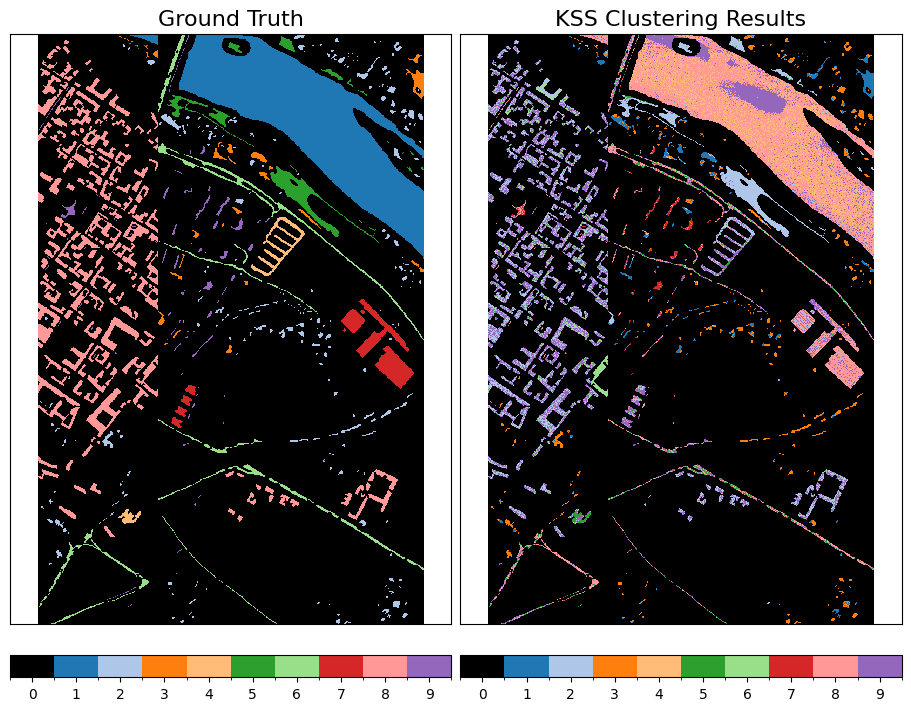

In [35]:
plot_gt_vs_clusters(gt_data, clustermap)